# 2026 QMW - Genomics Module

January 5, 2026

Author: Erik Owen | Graduate Student in Computational & Systems Biology | Page Lab

# Goals:

- QC summary from FASTQ
- Alignment (BAM) & index
- Coverage & MAPQ summaries
- Variant calls (VCF)
- Comparison to ground truth VCF

# Environment Setup

- download software tools + packages that we'll use in this tutorial
- download toy data

### What does `!` mean?

In Colab/Jupyter, you'll see lines that start with an exclamation mark, like `!ls` or `!bowtie2 --version`.

`!` tells the notebook: “run the rest of this line as a shell command (like you typed it in a Terminal), not as Python.”

- `!ls` lists files in the current folder
- `!pwd` prints the current folder path
- `!curl ...` is a command-line tool for data transfer
- `!zcat file.fastq.gz | head` runs a small pipeline of command-line tools
  - `|` is called a "pipe". This sends the output of the command on the left directly into the command on the right so you can "stream" results without creating intermediate files.

*Important*: `!` only works inside notebook cells. If you copy the same line into a .sh bash script, you must remove the `!` (because scripts are already “shell mode”).

In [17]:
!curl -L https://raw.githubusercontent.com/erik-owen/2026_QMW_Genomics/main/scripts/bootstrap_colab.sh | bash


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1751  100  1751    0     0  16538      0 --:--:-- --:--:-- --:--:-- 16676
> Installing tools...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 25.5M    0 25.5M    0     0  21.5M      0 --:--:--  0:00:01 --:--:-- 27.3M
Tools installed.

Tool versions:
/usr/bin/bowtie2-align-s version 2.4.4
samtools 1.13
bcftools 1.13

5.2
FastQC v0.11.9

> Downloading workshop data...
  - locus1_hg38_chr11_5215464_5237071_HBB.fa
  % Total    % Received % Xferd  Averag

The `tree` command is a UNIX command-line utility that shows your directory + file structure.

We'll be using it throughout the notebook to show you what files we're creating + using!

In [18]:
!tree

.
├── data
│   └── loci
│       ├── locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
│       ├── locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.fa
│       ├── locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.fa
│       ├── locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed
│       └── locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz
├── sample_data
│   ├── anscombe.json
│   ├── california_housing_test.csv
│   ├── california_housing_train.csv
│   ├── mnist_test.csv
│   ├── mnist_train_small.csv
│   └── README.md
└── work

4 directories, 13 files


In [19]:
#@title Select case study inputs
CASE = 1  #@param {type:"integer", min:1, max:2}
SAMPLE = "ind1_noHbS"  #@param ["ind1_noHbS", "ind2_HbS_carrier", "ind1_repeat_mix"]

from pathlib import Path

DATA = Path("data") / "loci"
assert DATA.exists(), f"Missing {DATA}. Did the bootstrap step run?"

FILES = {
    (1, "ind1_noHbS"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind1_noHbS.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (1, "ind2_HbS_carrier"): dict(
        ref=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.fa",
        reads=DATA / "locus1_HBB.ind2_HbS_carrier.reads_R1.fastq.gz",
        repeats=DATA / "locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed",
    ),
    (2, "ind1_repeat_mix"): dict(
        ref=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.fa",
        reads=DATA / "locus2_MTERF3_repeat.ind1_repeat_mix.reads_R1.fastq.gz",
        repeats=DATA / "locus2_hg38_chr8_96243643_96263643_MTERF3.repeats.local.bed",
    ),
}

paths = FILES[(CASE, SAMPLE)]
for k, p in paths.items():
    assert p.exists(), f"Missing {k}: {p}"
paths


{'ref': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa'),
 'reads': PosixPath('data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz'),
 'repeats': PosixPath('data/loci/locus1_hg38_chr11_5215464_5237071_HBB.repeats.local.bed')}

# Sequencing & File formats

## Inpsect a FASTA file

FASTA files is a text-based format for representing a sequence.

It has two parts:
- header: begins with `>`, + single line description of sequence
- sequence representation: 1 letter per nucleic acid

You've been provided 2 FASTA files. Go ahead and inpsect them using the command line:

- locus1_hg38_chr11_5215464_5237071_HBB.fa
- locus2_hg38_chr8_96243643_96263643_MTERF3.fa

In [20]:
!echo "FASTA heads:"
!echo
!head -n 3 data/loci/locus1_hg38_chr11_5215464_5237071_HBB.fa
!echo
!head -n 3 data/loci/locus2_hg38_chr8_96243643_96263643_MTERF3.fa


FASTA heads:

>locus1_hg38_chr11_5215464_5237071_HBB
GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGAT
GCAAGCCACTGTGCCCAGCTTGGCTCTTTCTTTTTATTTTAATTGGTCACTTTGTTTTCA

>locus2_hg38_chr8_96243643_96263643_MTERF3
TTTAAGGGAAGTGATCTATTCCAAAGTAAAGTAGAGAAAAACATGAGAGAGAAGAGAGAC
TACATTAGATTTGTTGGCCTGATTCCAACAATCAGAACTAGGACTAGGTAGAAACTCCAG


Now, using `python`, inspect our first case study. Return:
- FASTA header
- sequence length
- GC% content
- first 80 base pairs

Note: we've stored the paths to our data in: the paths dict. You want to select the `*.fa` file under `paths["ref"]`

In [21]:
import re # package for regular expressions

def read_fasta_one(path):
    header = None
    seq_chunks = []
    with open(path, "rt") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                header = line[1:]
            else:
                seq_chunks.append(line)
    if header is None:
        raise ValueError(f"No FASTA header found in {path}")
    seq = "".join(seq_chunks).upper()
    return header, seq

def gc_fraction(seq: str) -> float:
    gc = sum(1 for b in seq if b in ("G","C"))
    atgc = sum(1 for b in seq if b in ("A","T","G","C"))
    return (gc / atgc) if atgc else float("nan")

ref_path = paths["ref"]
header, ref_seq = read_fasta_one(ref_path)

print("FASTA:", ref_path.name)
print("Header:", header)
print("Length (bp):", len(ref_seq))
print("GC fraction:", round(gc_fraction(ref_seq), 4))
print("First 80 bp:", ref_seq[:80])

# Extract chr/start/end if present in header or filename
m = re.search(r"(chr[\w]+)[:_](\d+)[-_](\d+)", header) or re.search(r"(chr[\w]+)_(\d+)_(\d+)", ref_path.name)
if m:
    chrom, start, end = m.group(1), int(m.group(2)), int(m.group(3))
    print("Parsed locus:", chrom, start, end, "(span:", end-start, "bp )")


FASTA: locus1_hg38_chr11_5215464_5237071_HBB.fa
Header: locus1_hg38_chr11_5215464_5237071_HBB
Length (bp): 21607
GC fraction: 0.3827
First 80 bp: GAAATCCTGGGCTCAAGTGATCCTATCACTTCAGCCTCCTGGGTTACTGGGACTACAGATGCAAGCCACTGTGCCCAGCT
Parsed locus: chr11 5215464 5237071 (span: 21607 bp )


Does this FASTA represent:
- the whole human genome?
- 1 chromosome?
- a small region?

Why would your above answer be appropriate for a class setting?

Answer in MITx

## Inspect a FASTQ file

What do reads look like?

Using the command line, here are the first 2 records in our FASTQ file.

FASTQ files are composed of 4 lines. What do they signify?


In [22]:
!zcat data/loci/locus1_HBB.ind1_noHbS.reads_R1.fastq.gz | head -n 8

@ind1_noHbS_R1_1
CAGTTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTATAAATTACCTTGGGCAGTATGACCATTTTCACGATATTGATTCTTCCT
+
DGDB?ECACCADCEBDGBEI>E;C;<??>@><?;?>;<C=>A:=B<<6;<=?9>:;57;8::9;;:8=88999;9762<6445574:3;58393354513
@ind1_noHbS_R1_2
AGAAATCACCCGTCTTCTGCGTCACTCACGATGGGAGCTATAGACTGGAGCTGTTCCTATTCGGTCATCTTGGCTCCACCGCTCCCCCCCCCCTTTTTTT
+
G@BE=AC?DDAEDCA>@DBBB@C?ED>CB:=>BC?:=;C><@;@>79<=>;:<C<7>=;?=696=<87:67772648985375606:6:;562:22823/


Preview a few FASTQ records, then compute:

- number of reads
- read length
- quick quality summary + plot

In the next cell, please implement the function `phred33_to_q`

In [23]:
def phred33_to_q(qual: str):
  """
  Convert a FASTQ quality string (Phred+33 encoding) into numeric Q scores.

  Inputs:
  qual is string, see the assert checks for examples
  # See https://en.wikipedia.org/wiki/Phred_quality_score#Symbols for more

  Each character encodes a base quality:
    Q = ord(character) - 33

  Example:
    "I!" -> [40, 0]


  Returns
  -------
  list[int]
      One Q score per base; same length as `qual`.
  """
  # TODO
  # hint: use list comprehension for one-liner
  return [ord(c) - 33 for c in qual]

assert phred33_to_q("!") == [0]
assert phred33_to_q("I") == [40]
assert phred33_to_q("?") == [30]
assert phred33_to_q("I!I?") == [40, 0, 40, 30]
print("phred33_to_q sanity checks passed")

phred33_to_q sanity checks passed


In [24]:
import gzip
from statistics import mean

def fastq_iter_gz(path):
  opener = gzip.open if str(path).endswith(".gz") else open
  with opener(path, "rt") as f:
    while True:
      h = f.readline().rstrip()
      if not h:
        return
      s = f.readline().rstrip()
      plus = f.readline().rstrip()
      q = f.readline().rstrip()
      yield h, s, plus, q

def phred33_to_q(qual: str):
  '''
  Converts symbol to Q score
  '''
  return [ord(c) - 33 for c in qual]

reads_path = paths["reads"]

# Preview first 3 records
it = fastq_iter_gz(reads_path)
for i in range(3):
    h, s, plus, q = next(it)
    print("---- record", i+1, "----")
    print(h)
    print("seq (first 60):", s[:60], "...")
    print("qual(first 60):", q[:60], "...")
    print("len:", len(s), "meanQ:", round(mean(phred33_to_q(q)), 2))

# Stream stats
n_reads = 0
lengths = []
mean_qs = []

for h, s, plus, q in fastq_iter_gz(reads_path):
    n_reads += 1
    lengths.append(len(s))
    mean_qs.append(mean(phred33_to_q(q)))

---- record 1 ----
@ind1_noHbS_R1_1
seq (first 60): CAGTTCTGTGAAGAAAGTCATTGGTAGCTTGATGGGGATGGCATTGAATCTATAAATTAC ...
qual(first 60): DGDB?ECACCADCEBDGBEI>E;C;<??>@><?;?>;<C=>A:=B<<6;<=?9>:;57;8 ...
len: 100 meanQ: 26.85
---- record 2 ----
@ind1_noHbS_R1_2
seq (first 60): AGAAATCACCCGTCTTCTGCGTCACTCACGATGGGAGCTATAGACTGGAGCTGTTCCTAT ...
qual(first 60): G@BE=AC?DDAEDCA>@DBBB@C?ED>CB:=>BC?:=;C><@;@>79<=>;:<C<7>=;? ...
len: 100 meanQ: 26.82
---- record 3 ----
@ind1_noHbS_R1_3
seq (first 60): TATAAAAAATGGTGTGGGGGAGGGTTTGGAAAGATTTTTTGGGTAGTATAGAGAAGTTTA ...
qual(first 60): BBDFFGFFDEC?>F@AA@;;B?C>==9><B>>>@<CB9<>?B<<<8=9;=9;@??::839 ...
len: 100 meanQ: 26.42


In [25]:
# Teacher notebook: return all answers
print("\nFASTQ:", reads_path.name)
print("Reads:", n_reads)
print("Read length: min/mean/max =", min(lengths), round(mean(lengths), 2), max(lengths))
print("Mean Q (per-read): min/mean/max =", round(min(mean_qs),2), round(mean(mean_qs),2), round(max(mean_qs),2))



FASTQ: locus1_HBB.ind1_noHbS.reads_R1.fastq.gz
Reads: 2471
Read length: min/mean/max = 100 100 100
Mean Q (per-read): min/mean/max = 25.64 26.5 27.4


In [26]:
# Student notebook:
print("MITx checkpoint: submit the number of reads in this FASTQ.")
print("Sanity check: this is on the order of 10^3")


MITx checkpoint: submit the number of reads in this FASTQ.
Sanity check: this is on the order of 10^3


### Per-base quality profile

Now, we want to explore the quality of our reads which is given by our Phred quality scores:

$Q=-10\log_{10} P$

Where $P$ is the probability of an calling that base incorrectly!


In [27]:
import math

for Q in [10, 20, 30, 40]:
    p = 10 ** (-Q/10)
    print(f"Q={Q}: error probability ≈ {p:g} (≈ 1 in {round(1/p):,} bases)")


Q=10: error probability ≈ 0.1 (≈ 1 in 10 bases)
Q=20: error probability ≈ 0.01 (≈ 1 in 100 bases)
Q=30: error probability ≈ 0.001 (≈ 1 in 1,000 bases)
Q=40: error probability ≈ 0.0001 (≈ 1 in 10,000 bases)


In [28]:
# Student notebook:
print("MITx checkpoint: What is the mean Q per-read in our raw FASTQ file?")
print("Does this make you worry about the errors? Think about the frequency of SNPs in a given human.")


MITx checkpoint: What is the mean Q per-read in our raw FASTQ file?
Does this make you worry about the errors? Think about the frequency of SNPs in a given human.


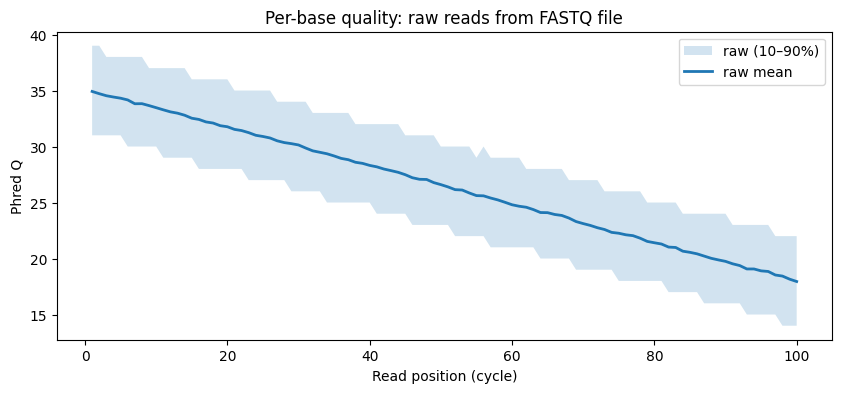

Raw reads processed: 2471
Raw mean Q by cycle:    min/median/max = 17.95 26.5 34.92


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def fastq_iter_gz(path):
    opener = gzip.open if str(path).endswith(".gz") else open
    with opener(path, "rt") as f:
        while True:
            h = f.readline().rstrip()
            if not h:
                return
            s = f.readline().rstrip()
            plus = f.readline().rstrip()
            q = f.readline().rstrip()
            yield h, s, plus, q

def per_base_q_profile(fastq_path, min_count_per_cycle=50):
    """
    Returns dict with x (1-based cycles), mean, p10, p90, n_reads.
    For variable-length reads (trimmed), cycles with <min_count_per_cycle are dropped.
    """
    per_cycle = []  # list of lists of Q values
    n_reads = 0

    for _, s, _, qstr in fastq_iter_gz(fastq_path):
        q = phred33_to_q(qstr)
        if len(per_cycle) < len(q):
            per_cycle.extend([[] for _ in range(len(q) - len(per_cycle))])
        for i, qi in enumerate(q):
            per_cycle[i].append(int(qi))
        n_reads += 1

    # Convert to arrays and compute stats, keeping only cycles with enough observations
    means, p10s, p90s, xs = [], [], [], []
    for i, vals in enumerate(per_cycle):
        if len(vals) < min_count_per_cycle:
            continue
        v = np.array(vals, dtype=np.int16)
        xs.append(i + 1)  # 1-based cycle
        means.append(float(v.mean()))
        p10s.append(float(np.percentile(v, 10)))
        p90s.append(float(np.percentile(v, 90)))

    return {
        "x": np.array(xs, dtype=int),
        "mean": np.array(means, dtype=float),
        "p10": np.array(p10s, dtype=float),
        "p90": np.array(p90s, dtype=float),
        "n_reads": n_reads,
    }

# Paths
reads_raw = paths["reads"]
raw = per_base_q_profile(reads_raw, min_count_per_cycle=50)

plt.figure(figsize=(10,4))

# Raw: gray band + black mean line
plt.fill_between(raw["x"], raw["p10"], raw["p90"], alpha=0.20, label="raw (10–90%)")
plt.plot(raw["x"], raw["mean"], linewidth=2, label="raw mean")

plt.xlabel("Read position (cycle)")
plt.ylabel("Phred Q")
plt.title("Per-base quality: raw reads from FASTQ file")
plt.legend()
plt.show()

print("Raw reads processed:", raw["n_reads"])
print("Raw mean Q by cycle:    min/median/max =",
      round(raw["mean"].min(),2), round(np.median(raw["mean"]),2), round(raw["mean"].max(),2))

Does the quality drop at the 3' end? Why might you think so?

Hint: Think back to sequencing-by-synthesis and the optical readout!

## Quality trimming

Here, we are going to use the tool TrimGalore to remove low quality portions of our read!

This is a pretty typical part of the QC pipeline

https://github.com/FelixKrueger/TrimGalore/tree/master

In [30]:
# Precompute Trim Galore outputs for all FASTQs
from pathlib import Path

Q_TRIM = 25
MIN_LEN = 50

WORK = Path("work")
WORK.mkdir(exist_ok=True)

def work_dir(case: int, sample: str) -> Path:
    d = WORK / f"case{case}_{sample}"
    d.mkdir(parents=True, exist_ok=True)
    return d

def trimmed_fastq_path(case: int, sample: str) -> Path:
    """
    Expected trimmed FASTQ location (Trim Galore naming convention):
      <outdir>/<basename>_trimmed.fq.gz
    """
    reads = FILES[(case, sample)]["reads"]
    outdir = work_dir(case, sample) / "trim_galore"
    outdir.mkdir(parents=True, exist_ok=True)

    # Trim Galore outputs either *_trimmed.fq.gz or *_trimmed.fastq.gz depending on inputs/version
    expected1 = outdir / (reads.name.replace(".fastq.gz", "_trimmed.fq.gz"))
    expected2 = outdir / (reads.name.replace(".fastq.gz", "_trimmed.fastq.gz"))
    return expected1 if expected1.exists() else expected2

def run_trim_galore(case: int, sample: str) -> Path:
    reads = FILES[(case, sample)]["reads"]
    outdir = work_dir(case, sample) / "trim_galore"
    outdir.mkdir(parents=True, exist_ok=True)

    # If already trimmed, skip
    existing = sorted(outdir.glob("*_trimmed.f*q.gz"))
    if existing:
        return existing[0]

    print(f"\n=== Trimming: case{case} / {sample} ===")
    print("Input:", reads)
    print("Outdir:", outdir)


    # !!! IMPORTANT HERE'S THE TRIM GALORE COMMAND !!!
    # Run Trim Galore (single-end)
    !trim_galore --quality {Q_TRIM} --length {MIN_LEN} --fastqc --gzip -o {outdir} {reads}

    trimmed = sorted(outdir.glob("*_trimmed.f*q.gz"))
    assert trimmed, f"Trim Galore finished but no trimmed FASTQ found in {outdir}"
    return trimmed[0]

# Run for all defined samples
trimmed_map = {}
for (case, sample) in FILES.keys():
    trimmed_path = run_trim_galore(case, sample)
    trimmed_map[(case, sample)] = trimmed_path
    print("Trimmed FASTQ:", trimmed_path)

print("\nDone. Trimmed files available for later alignment:")
trimmed_map



FileNotFoundError: [Errno 2] No such file or directory: 'work/case1_ind1_noHbS/trim_galore'

In [ ]:
!tree

In [ ]:
trimmed = sorted(outdir.glob("*_trimmed.fq.gz")) + sorted(outdir.glob("*_trimmed.fastq.gz"))
assert len(trimmed) == 1, f"Expected 1 trimmed file, found: {trimmed}"
reads_trimmed = trimmed[0]
reads_trimmed

import gzip, numpy as np

def fastq_stats_gz(path):
    n = 0
    lens = []
    with gzip.open(path, "rt") as f:
        while True:
            h = f.readline()
            if not h:
                break
            s = f.readline().rstrip()
            f.readline()
            f.readline()
            n += 1
            lens.append(len(s))
    lens = np.array(lens)
    return n, int(lens.min()), float(lens.mean()), int(lens.max())

n0, mn0, av0, mx0 = fastq_stats_gz(reads_in)
n1, mn1, av1, mx1 = fastq_stats_gz(reads_trimmed)

print("RAW    reads:", n0, "len min/mean/max:", mn0, round(av0,2), mx0)
print("TRIM   reads:", n1, "len min/mean/max:", mn1, round(av1,2), mx1)

# Student notebook: replace the second print with an MITx prompt if desired
print("MITx checkpoint: submit trimmed read count and mean trimmed length.")


In [ ]:
# Paths
reads_raw = paths["reads"]
reads_trimmed = reads_trimmed  # from your Trim Galore step

raw = per_base_q_profile(reads_raw, min_count_per_cycle=50)
trim = per_base_q_profile(reads_trimmed, min_count_per_cycle=50)

plt.figure(figsize=(10,4))

# Raw: gray band + black mean line
plt.fill_between(raw["x"], raw["p10"], raw["p90"], alpha=0.20, label="raw (10–90%)")
plt.plot(raw["x"], raw["mean"], linewidth=2, label="raw mean")

# Trimmed: blue band + blue mean line
# (Matplotlib default blue; no need to specify if you prefer default)
plt.fill_between(trim["x"], trim["p10"], trim["p90"], alpha=0.20, label="trimmed (10–90%)")
plt.plot(trim["x"], trim["mean"], linewidth=2, label="trimmed mean")

plt.xlabel("Read position (cycle)")
plt.ylabel("Phred Q")
plt.title("Per-base quality: raw vs trimmed")
plt.legend()
plt.show()

print("Raw reads processed:", raw["n_reads"])
print("Trimmed reads processed:", trim["n_reads"])
print("Raw mean Q by cycle:    min/median/max =",
      round(raw["mean"].min(),2), round(np.median(raw["mean"]),2), round(raw["mean"].max(),2))
print("Trimmed mean Q by cycle: min/median/max =",
      round(trim["mean"].min(),2), round(np.median(trim["mean"]),2), round(trim["mean"].max(),2))


In [ ]:
def read_lengths(fastq_path):
    lens = []
    for _, s, _, _ in fastq_iter_gz(fastq_path):
        lens.append(len(s))
    return np.array(lens, dtype=int)

lens_raw  = read_lengths(reads_raw)
lens_trim = read_lengths(reads_trimmed)

med_raw  = int(np.median(lens_raw))
med_trim = int(np.median(lens_trim))

plt.figure(figsize=(10,4))

# Plot histograms and capture the returned patches to reuse their colors
counts_raw, bins_raw, patches_raw = plt.hist(lens_raw, bins=20, alpha=0.35, label="raw")
counts_tr,  bins_tr,  patches_tr  = plt.hist(lens_trim, bins=20, alpha=0.35, label="trimmed")

raw_color  = patches_raw[0].get_facecolor()
trim_color = patches_tr[0].get_facecolor()

# Median lines in matching colors
plt.axvline(med_raw,  linewidth=2, color=raw_color,  label=f"raw median = {med_raw} bp")
plt.axvline(med_trim, linewidth=2, color=trim_color, label=f"trimmed median = {med_trim} bp")

plt.xlabel("Read length (bp)")
plt.ylabel("Number of reads")
plt.title("Read length distribution: raw vs trimmed")
plt.legend()
plt.show()

print("Raw lengths:     n/min/median/mean/max =",
      len(lens_raw), lens_raw.min(), med_raw, round(lens_raw.mean(),2), lens_raw.max())
print("Trimmed lengths: n/min/median/mean/max =",
      len(lens_trim), lens_trim.min(), med_trim, round(lens_trim.mean(),2), lens_trim.max())


### Run the following cell to get the full QC report from running `fastQC` as part of `TrimGalore`

In [ ]:
from google.colab import files

trim_dir = outdir

# Find the HTML report
html_candidates = sorted(trim_dir.glob("*_fastqc.html"))
assert html_candidates, f"No *_fastqc.html found in {trim_dir}. Did you run Trim Galore with --fastqc?"

html_path = html_candidates[0]

print("FastQC report found at:", html_path)
print("Instructions:")
print("1) This notebook will download the FastQC HTML report to your computer.")
print("2) Open the downloaded file (fastqc_report.html) in your web browser.")
print("3) Skim these sections: Per base sequence quality, Per sequence quality scores,")
print("   Per base sequence content, Sequence Length Distribution")

# Trigger download
files.download(str(html_path))


## Trim all FASTQs in toy data

This precomputes all TrimGalore outputs for all toy FASTQs.

This way we don't have to redo this section for the other provided FASTQs

In [ ]:
# Precompute Trim Galore outputs for all FASTQs
from pathlib import Path

Q_TRIM = 25
MIN_LEN = 50

WORK = Path("work")
WORK.mkdir(exist_ok=True)

def work_dir(case: int, sample: str) -> Path:
    d = WORK / f"case{case}_{sample}"
    d.mkdir(parents=True, exist_ok=True)
    return d

def trimmed_fastq_path(case: int, sample: str) -> Path:
    """
    Expected trimmed FASTQ location (Trim Galore naming convention):
      <outdir>/<basename>_trimmed.fq.gz
    """
    reads = FILES[(case, sample)]["reads"]
    outdir = work_dir(case, sample) / "trim_galore"
    outdir.mkdir(parents=True, exist_ok=True)

    # Trim Galore outputs either *_trimmed.fq.gz or *_trimmed.fastq.gz depending on inputs/version
    expected1 = outdir / (reads.name.replace(".fastq.gz", "_trimmed.fq.gz"))
    expected2 = outdir / (reads.name.replace(".fastq.gz", "_trimmed.fastq.gz"))
    return expected1 if expected1.exists() else expected2

def run_trim_galore(case: int, sample: str) -> Path:
    reads = FILES[(case, sample)]["reads"]
    outdir = work_dir(case, sample) / "trim_galore"
    outdir.mkdir(parents=True, exist_ok=True)

    # If already trimmed, skip
    existing = sorted(outdir.glob("*_trimmed.f*q.gz"))
    if existing:
        return existing[0]

    print(f"\n=== Trimming: case{case} / {sample} ===")
    print("Input:", reads)
    print("Outdir:", outdir)

    # Run Trim Galore (single-end)
    !trim_galore --quality {Q_TRIM} --length {MIN_LEN} --fastqc --gzip -o {outdir} {reads}

    trimmed = sorted(outdir.glob("*_trimmed.f*q.gz"))
    assert trimmed, f"Trim Galore finished but no trimmed FASTQ found in {outdir}"
    return trimmed[0]

# Run for all defined samples
trimmed_map = {}
for (case, sample) in FILES.keys():
    trimmed_path = run_trim_galore(case, sample)
    trimmed_map[(case, sample)] = trimmed_path
    print("Trimmed FASTQ:", trimmed_path)

print("\nDone. Trimmed files available for later alignment:")
trimmed_map


In [ ]:
!tree ./work/

## Finish answering questions in the MITx section before moving on to alignment

# Alignment


We will use `bowtie2` to align our trimmed reads to our reference FASTA.

Let's start with the CASE and SAMPLE we defined at the top of this notebook.

In [ ]:
from pathlib import Path
import glob

WORK = Path("work")
WORK.mkdir(exist_ok=True)

# Where trim_galore outputs went (based on your folder structure)
case_dir = WORK / f"case{CASE}_{SAMPLE}"
trim_dir = case_dir / "trim_galore"
assert trim_dir.exists(), f"Missing {trim_dir}. Run trimming first."

ref_fa = FILES[(CASE, SAMPLE)]["ref"]

# Find the trimmed FASTQ produced by trim_galore (single-end)
trimmed = list(trim_dir.glob("*_trimmed.fq.gz"))
assert len(trimmed) == 1, f"Expected 1 trimmed FASTQ in {trim_dir}, found: {trimmed}"
trimmed_fq = trimmed[0]

print("CASE:", CASE, "SAMPLE:", SAMPLE)
print("REF:", ref_fa)
print("TRIMMED:", trimmed_fq)


## Build bowtie2 index

We build an reference index for the locus. Otherwise, we wouldn't have anything to align to!

In [ ]:
idx_dir = case_dir / "bowtie2_index"
idx_dir.mkdir(exist_ok=True)
idx_prefix = idx_dir / "ref"

!bowtie2-build "{ref_fa}" "{idx_prefix}"
!ls -lh "{idx_dir}"

## Align reads

We will run 2 alignments to compare:

- `Bowtie2` default which does end-to-end pairing
- `--very-sensitive-local`

In [ ]:
aln_dir = case_dir / "alignments"
aln_dir.mkdir(exist_ok=True)

sam_default = aln_dir / "aln.default.sam"
sam_vsl     = aln_dir / "aln.vslocal.sam"

In [ ]:
# 1) Default alignment (end-to-end)
!bowtie2 -x "{idx_prefix}" -U "{trimmed_fq}" -S "{sam_default}" 2> "{sam_default}.log"

# 2) Very-sensitive LOCAL alignment
!bowtie2 --very-sensitive-local -x "{idx_prefix}" -U "{trimmed_fq}" -S "{sam_vsl}" 2> "{sam_vsl}.log"

# Show Bowtie2 summaries (mapping rate, etc.)
!tail -n 20 "{sam_default}.log"
!echo "----"
!tail -n 20 "{sam_vsl}.log"

## Convert SAM to BAM and provide mapping summaries

- SAM $:=$ sequence alignment map
- BAM $:=$ binary alignment map

SAM is a text-based format for storing sequences aligned to a reference sequence.

BAM is the lossless, compressed binary version of a SAM


Why do we index?

- Quickly retrive alignments that overlap specific location
- We sort our files to do this

In [ ]:
def bam_paths(sam_path: Path):
    bam = sam_path.with_suffix(".bam")
    sortbam = sam_path.with_suffix(".sorted.bam")
    return bam, sortbam

bam_def, sort_def = bam_paths(sam_default)
bam_vsl, sort_vsl = bam_paths(sam_vsl)


In [ ]:
# Default BAM
!samtools view -bS "{sam_default}" > "{bam_def}"
!samtools sort -o "{sort_def}" "{bam_def}"
!samtools index "{sort_def}"

# Very-sensitive-local BAM
!samtools view -bS "{sam_vsl}" > "{bam_vsl}"
!samtools sort -o "{sort_vsl}" "{bam_vsl}"
!samtools index "{sort_vsl}"

### SAM field guide

| Col | Field | Type   | Brief description                         |
|-----|-------|--------|--------------------------------------------|
| 1   | QNAME | String | Query template NAME                        |
| 2   | FLAG  | Int    | bitwise FLAG                               |
| 3   | RNAME | String | Reference sequence NAME                    |
| 4   | POS   | Int    | 1-based leftmost mapping POSition          |
| 5   | MAPQ  | Int    | MAPping Quality                            |
| 6   | CIGAR | String | CIGAR string                               |
| 7   | RNEXT | String | Ref. name of the mate/next read            |
| 8   | PNEXT | Int    | Position of the mate/next read             |
| 9   | TLEN  | Int    | observed Template LENgth                   |
| 10  | SEQ   | String | segment SEQuence                           |
| 11  | QUAL  | String | ASCII of Phred-scaled base QUALity + 33    |



In [ ]:
!samtools view -h "{sort_def}" | head -n 30
